In [1]:

import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
import habitat
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf
from habitat.articulated_agent_controllers import (
    HumanoidRearrangeController,
    HumanoidSeqPoseController,
)
from habitat.config.default_structured_configs import HumanoidJointActionConfig, HumanoidPickActionConfig



/home/minwook0008/bin/anaconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pybullet build time: Apr 11 2024 18:25:41


# chat system 

In [2]:
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = "data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json"
    sim_cfg.scene_dataset = "data/hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json"
    sim_cfg.additional_object_paths = ['data/objects/ycb/configs/']

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [3]:
# agenet 0 setting 
main_agent_config = AgentConfig() 
urdf_path = "data/humanoids/humanoid_data/female_0/female_0.urdf"
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "KinematicHumanoid"
main_agent_config.motion_data_path = "data/humanoids/humanoid_data/female_0/female_0_motion_data_smplx.pkl"

main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# agenet 1 setting 
sub_agent_config = AgentConfig()
urdf_path = "data/humanoids/humanoid_data/male_0/male_0.urdf"
sub_agent_config.articulated_agent_urdf = urdf_path
sub_agent_config.articulated_agent_type = "KinematicHumanoid"
sub_agent_config.motion_data_path = "data/humanoids/humanoid_data/male_0/male_0_motion_data_smplx.pkl"

sub_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# multi agent setting
agent_dict = {"agent_0": main_agent_config, "agent_1": sub_agent_config}
action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig(),
    "humanoid_navigate_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
                                                      motion_control="human_joints",
                                                      spawn_max_dist_to_obj=1.0),
    "humanoid_pick_obj_id_action": HumanoidPickActionConfig(type="HumanoidPickObjIdAction")
    
}

multi_agent_action_dict = {}
for action_name, action_config in action_dict.items():
    for agent_id in range(2):
        multi_agent_action_dict[f"agent_{agent_id}_{action_name}"] = action_config 
env = init_rearrange_env(agent_dict, multi_agent_action_dict)

2024-07-11 14:28:50,330 Initializing dataset RearrangeDataset-v0
2024-07-11 14:28:50,337 initializing sim RearrangeSim-v0
[14:28:52:250220]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:28:52:250333]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[14:28:52:250347]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[14:28:52:250354]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAt

Renderer: NVIDIA RTX A6000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


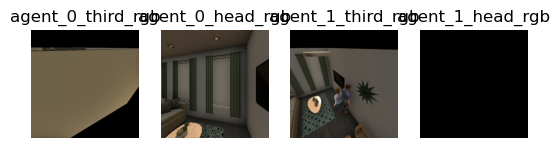

In [4]:
observations = env.reset()
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

In [8]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
observations = []

# Walk towards the object
agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
     
    
    action_dict = {
        "action": ("agent_0_humanoid_navigate_action","agent_1_humanoid_navigate_action"), 
        "action_args": {
            "agent_0_oracle_nav_lookat_action": object_trans,
            "agent_0_mode": 1,
            "agent_1_oracle_nav_lookat_action": object_trans,
            "agent_1_mode": 1
          }
        }
    observations.append(env.step(action_dict))
    
    
    cur_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    cur_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    
    # print(agent_rot, agent_displ)


for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))

# Pick object
observations.append(env.step(action_dict))
for _ in range(100):
        
    action_dict = {"action": ("agent_0_humanoid_pick_obj_id_action", "agent_1_humanoid_pick_obj_id_action"), 
                   "action_args": {
                       "agent_0_humanoid_pick_obj_id": obj_id,
                       "agent_1_humanoid_pick_obj_id": obj_id,
                    }
                   }
    observations.append(env.step(action_dict)) 


vut.make_video(
    observations,
    "agent_0_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


Encoding the video: robot_tutorial_video.mp4 


In [ ]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
observations = []

# Walk towards the object
agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
     
    
    action_dict = {
        "action": ("agent_0_humanoid_navigate_action","agent_1_humanoid_navigate_action"), 
        "action_args": {
            "agent_0_oracle_nav_lookat_action": object_trans,
            "agent_0_mode": 1,
            "agent_1_oracle_nav_lookat_action": object_trans,
            "agent_1_mode": 1
          }
        }
    observations.append(env.step(action_dict))
    
    
    cur_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    cur_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    
    # print(agent_rot, agent_displ)

# conversation setting 


for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))

# Pick object
observations.append(env.step(action_dict))
for _ in range(100):
        
    action_dict = {"action": ("agent_0_humanoid_pick_obj_id_action", "agent_1_humanoid_pick_obj_id_action"), 
                   "action_args": {
                       "agent_0_humanoid_pick_obj_id": obj_id,
                       "agent_1_humanoid_pick_obj_id": obj_id,
                    }
                   }
    observations.append(env.step(action_dict)) 


vut.make_video(
    observations,
    "agent_0_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


# other scene import    

In [2]:
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = "/data/replica_cad/configs/scenes/apt_0.scene_instance.json"
    sim_cfg.scene_dataset = "/data/replica_cad/replicaCAD.scene_dataset_config.json"
    sim_cfg.additional_object_paths = ['data/objects/ycb/configs/']

    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/datasets/rearrange_pick/replica_cad/v0/rearrange_pick_replica_cad_v0/test/test_counter_L_analysis_5000_500.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [3]:
# Define the agent configuration
main_agent_config = AgentConfig()
urdf_path = "data/hab3_bench_assets/humanoids/female_0/female_0.urdf"
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "KinematicHumanoid"
main_agent_config.motion_data_path = "data/hab3_bench_assets/humanoids/female_0/female_0_motion_data_smplx.pkl"


# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why giving the sensors these names
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
agent_dict = {"main_agent": main_agent_config}


In [17]:
agent_dict = {"agent_0": main_agent_config, "agent_1": sub_agent_config}
action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig(),
    "humanoid_navigate_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
                                                      motion_control="human_joints",
                                                      spawn_max_dist_to_obj=1.0),
    "humanoid_pick_obj_id_action": HumanoidPickActionConfig(type="HumanoidPickObjIdAction")
    
}

multi_agent_action_dict = {}
for action_name, action_config in action_dict.items():
    for agent_id in range(2):
        multi_agent_action_dict[f"agent_{agent_id}_{action_name}"] = action_config 
env = init_rearrange_env(agent_dict, multi_agent_action_dict)

2024-07-08 10:52:26,470 Initializing dataset RearrangeDataset-v0


TypeError: __init__() got an unexpected keyword argument 'scene_config_path'